<div style="text-align: center; font-size: 20px; font-weight: bold;">
<h1>ACC5 - Forecasting Day 2 Homework: Creating a Forecasting model</h1>
</div>

## Introduction

In this homework, the focus shifts to building your first time series forecast. You'll explore key steps in the forecasting workflow, including data preprocessing, feature engineering, and model validation. A notebook with the graphical exploration of a dataset will be provided as a starting point.

**Tasks**

1. **Get Familiar with Forecasting Libraries**  
   - Practice using a forecasting library of your choice.  
   - It is recommended to use [skforecast](https://skforecast.org) for this assignment, but feel free to experiment with other libraries such as `sktime`, `darts`, `aeon` or `nixtla`.

2. **Create a Recursive Multi-Step Forecaster**  
   - Build a model capable of forecasting multiple steps ahead by using its own predictions recursively.  
   - You can use the [`ForecasterRecursive`](https://skforecast.org/latest/user_guides/autoregresive-forecaster) from `skforecast` to implement this approach.
   - You can include lags and window features in your model to improve forecast accuracy.
   - Visualize the multi-step predictions and compare them to the actual data.

3. **Feature Engineering and Exogenous Features**  
   - Identify and include **exogenous variables** (features that are not part of the main time series but might influence it).
   - Example: weather data, holidays or calendar features.
   - You can create additional features such as rolling means, ciclical encoding, or polynomial interactions with this exogenous data.
   - [Exogenous variables in skforecast](https://skforecast.org/latest/user_guides/exogenous-variables).

4. **Backtesting**  
   - Define your **backtesting strategy** to evaluate the performance of your model **base on the use case information**.
   - Perform backtesting to evaluate your model's performance on historical data.
   - Report key metrics (e.g., MAE, RMSE) for the forecasts.
   - [Backtesting in skforecast](https://skforecast.org/latest/user_guides/backtesting).

5. **Optimization and Validation**  
   - Optimize your forecasting model by tuning hyperparameters.  
   - Validate the model using appropriate methods, such as **backtesting** or **one-step-ahead** validation.
   - [Hyperparameter tuning and lags selection in skforecast](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection).
   - After tuning, re-evaluate the model's performance using the same **backtesting** strategy.

6. **Feature Importance and Selection**  
   - Evaluate the importance of each feature in the model.  
   - [Forecaster explainability: Feature importance, SHAP Values and Partial Dependence Plots in skforecast](https://skforecast.org/latest/user_guides/explainability).
   - Select the most relevant features to improve forecast accuracy.
   - [Feature selection in skforecast](https://skforecast.org/latest/user_guides/feature-selection).

**Deliverables**

- A notebook containing your modeling process, and forecasts.  
- Visualizations to support your analysis and results.  
- A summary of your approach, key observations, and conclusions.

## Libraries

Make sure you are using skforecast `0.14.0`.

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

## Use case information

The data in this document represent the hourly usage of the bike share system in the city of Washington, D.C. during the years 2011 and 2012. In addition to the number of users per hour, information about weather conditions and holidays is available. The original data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

**The model is used to predict the number of bikes that will be rented in a bike-sharing system over the next 36 hours. Once the model goes into production, it will be retrained every 7 prediction cycles.**

In [2]:
# Downloading data
# ==============================================================================
data = fetch_dataset('bike_sharing')
data = data.drop(columns=['hour', 'weekday', 'month'])
data.head(4)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,holiday,workingday,weather,temp,atemp,hum,windspeed,users
date_time,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0
2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0,13.0


To facilitate the training of the models, the search for optimal hyperparameters and the evaluation of their predictive accuracy, the data are divided into three separate sets: training, validation and test.

In [3]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


## Data exploration

Graphical exploration of time series can be an effective way of identifying trends, patterns, and seasonal variations. This, in turn, helps to guide the selection of the most appropriate forecasting model.

### Plot time series

**Full time series**

In [4]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Seasonality plots

Seasonal plots are a useful tool for identifying seasonal patterns and trends in a time series. They are created by averaging the values of each season over time and then plotting them against time.

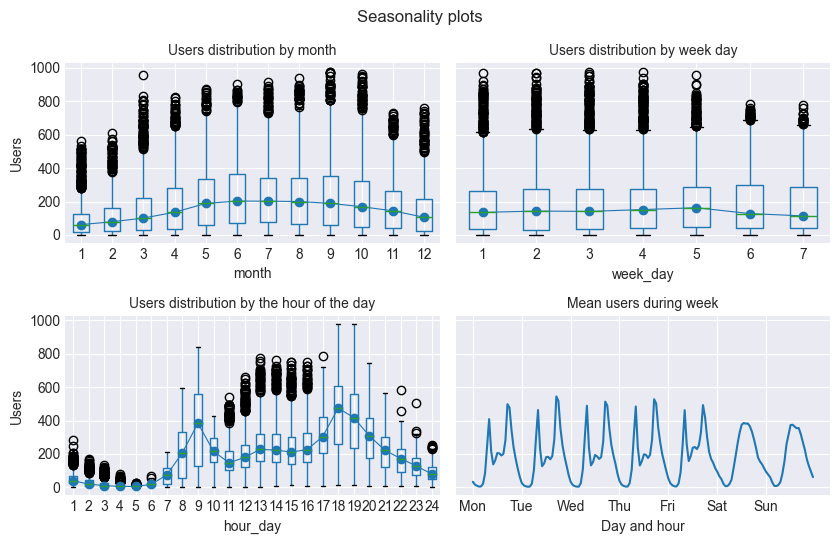

In [5]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8.5, 5.5), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0])
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month', fontsize=10)

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1])
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day', fontsize=10)

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2])
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day', fontsize=10)

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)
axs[3].title.set_size(10)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

There is a clear difference between weekdays and weekends. There is also a clear intra-day pattern, with a different influx of users depending on the time of day.

### Autocorrelation plots

Auto-correlation plots are a useful tool for identifying the order of an autoregressive model. The autocorrelation function (ACF) is a measure of the correlation between the time series and a lagged version of itself. The partial autocorrelation function (PACF) is a measure of the correlation between the time series and a lagged version of itself, controlling for the values of the time series at all shorter lags. These plots are useful for identifying the lags to be included in the autoregressive model.

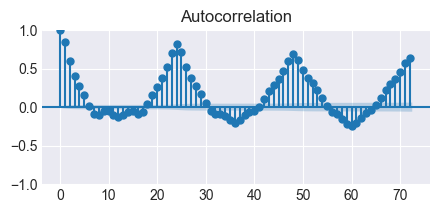

In [6]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

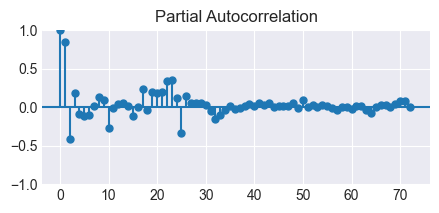

In [7]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before, and the number of users in the future. This means that knowing the number of users during certain periods in the past could be valuable in predicting the number of users in the future.

## Forecasting

### 1. Get Familiar with Forecasting Libraries
- Practice using a forecasting library of your choice.
- It is recommended to use [skforecast](https://skforecast.org) for this assignment, but feel free to experiment with other libraries such as `sktime`, `darts`, `aeon` or `nixtla`.

### 2. Create a Recursive Multi-Step Forecaster
- Build a model capable of forecasting multiple steps ahead by using its own predictions recursively.
- You can use the [`ForecasterRecursive`](https://skforecast.org/latest/user_guides/autoregresive-forecaster) from `skforecast` to implement this approach.
- You can include lags and window features in your model to improve forecast accuracy.
- Visualize the multi-step predictions and compare them to the actual data.


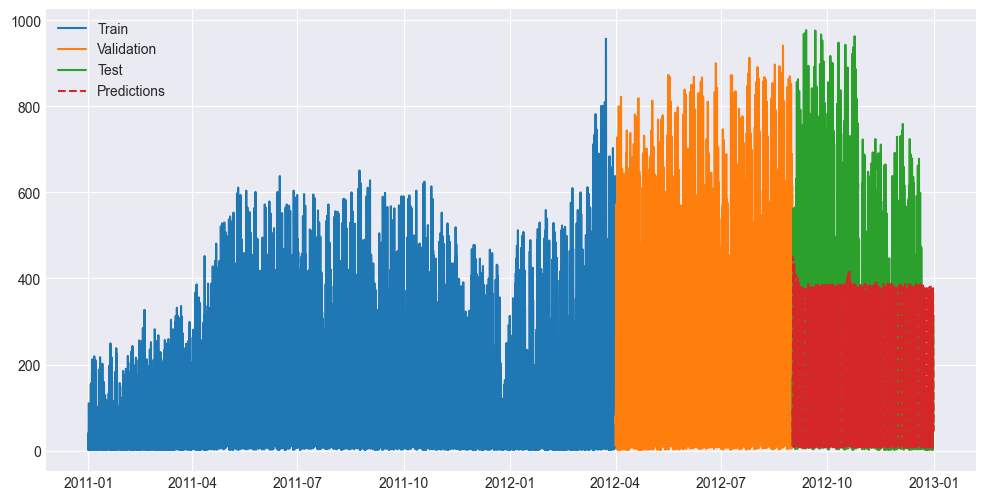

In [27]:
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=42), 
    lags            = 10,
    window_features = RollingFeatures(stats=['mean'], window_sizes=24)
)

forecaster.fit(y=data_train['users'])

steps_ahead = len(data_test)  # Forecast the same number of steps as test set
predictions = forecaster.predict(steps=steps_ahead)

# 5. Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(data_train['users'], label='Train')
plt.plot(data_val['users'], label='Validation')
plt.plot(data_test['users'], label='Test')
plt.plot(data_test.index, predictions, label='Predictions', linestyle='--')
plt.legend()
plt.show()



In [28]:
# 6. Evaluate Performance
rmse = np.sqrt(mean_squared_error(data_test['users'], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")


Root Mean Squared Error (RMSE): 195.714


### 3. Feature Engineering and Exogenous Features
- Identify and include **exogenous variables** (features that are not part of the main time series but might influence it).
- Example: weather data, holidays or calendar features.
- You can create additional features such as rolling means, ciclical encoding, or polynomial interactions with this exogenous data.
- [Exogenous variables in skforecast](https://skforecast.org/latest/user_guides/exogenous-variables).


In [24]:
steps_ahead = len(data_test)
print(f"Steps ahead: {steps_ahead}")

Steps ahead: 2928


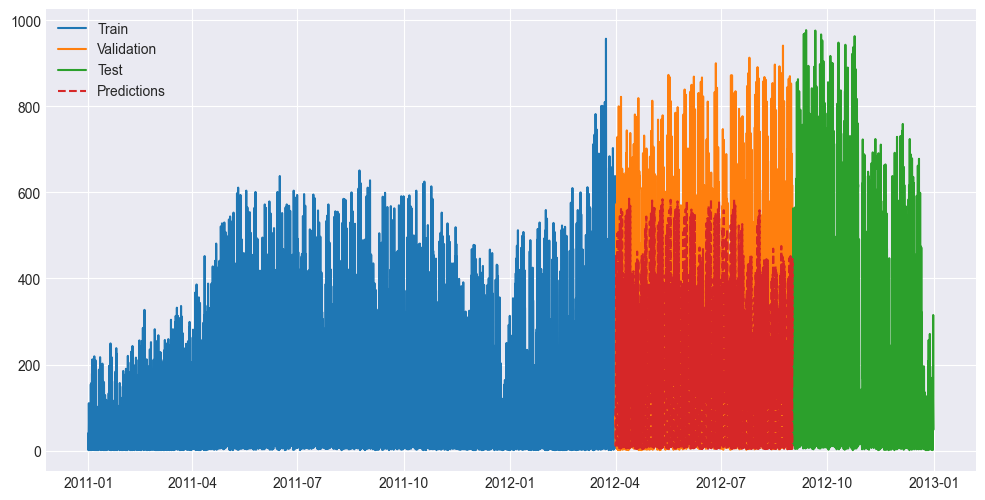

In [25]:
# Define exogenous variables
exog_train = data_train[['holiday', 'workingday']]
exog_val = data_val[['holiday', 'workingday']]
exog_test = data_test[['holiday', 'workingday']]

# Update the forecaster to include exogenous variables
forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=42), 
    lags=10,
    window_features=RollingFeatures(stats=['mean'], window_sizes=24)
)

# Fit the forecaster with exogenous variables
forecaster.fit(y=data_train['users'], exog=exog_train)

# Make predictions using exogenous variables
steps_ahead = len(data_val)
predictions = forecaster.predict(steps=steps_ahead, exog=exog_val)

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(data_train['users'], label='Train')
plt.plot(data_val['users'], label='Validation')
plt.plot(data_test['users'], label='Test')
plt.plot(data_val.index, predictions, label='Predictions', linestyle='--')
plt.legend()
plt.show()

In [26]:
# Evaluate Performance
rmse = np.sqrt(mean_squared_error(data_val['users'], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Root Mean Squared Error (RMSE): 265.591


### 4. Backtesting
- Define your **backtesting strategy** to evaluate the performance of your model **base on the use case information**.
- Perform backtesting to evaluate your model's performance on historical data.
- Report key metrics (e.g., MAE, RMSE) for the forecasts.
- [Backtesting in skforecast](https://skforecast.org/latest/user_guides/backtesting).


In [ ]:
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster 


forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=42), 
    lags=10,
    window_features=RollingFeatures(stats=['mean'], window_sizes=24)
)

cv = TimeSeriesFold(
         steps                 = 36,
         initial_train_size    = len(data_train),
         refit                 = 7,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['users'],
                          exog          = data[['holiday', 'workingday']],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 10944
Number of observations used for backtesting: 6600
    Number of folds: 184
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-03-31 23:00:00  (n=10944)
    Validation: 2012-04-01 00:00:00 -- 2012-04-02 11:00:00  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 2012-04-02 12:00:00 -- 2012-04-03 23:00:00  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 2012-04-04 00:00:00 -- 2012-04-05 11:00:00  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 2012-04-05 12:00:00 -- 2012-04-06 23:00:00  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 2012-04-07 00:00:00 -- 2012-04-08 11:00:00  (n=36)
Fold: 5
    T

100%|██████████| 184/184 [02:58<00:00,  1.03it/s]


In [32]:
display(metric)
predictions.head(4)

,mean_squared_error
0,18643.787574


,pred
2012-04-01 00:00:00,94.30
2012-04-01 01:00:00,55.52
2012-04-01 02:00:00,32.71
2012-04-01 03:00:00,13.82


In [38]:
#rmse
rmse = np.sqrt(metric)
print(rmse)

   mean_squared_error
0          136.542256


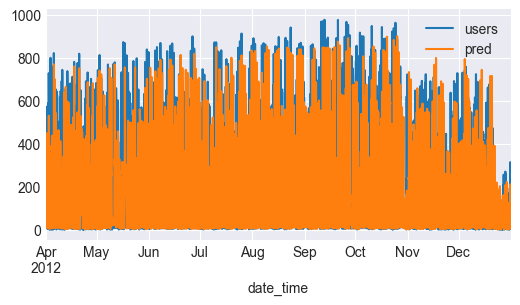

In [33]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'users'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

### 5. Optimization and Validation
- Optimize your forecasting model by tuning hyperparameters.
- Validate the model using appropriate methods, such as **backtesting** or **one-step-ahead** validation.
- [Hyperparameter tuning and lags selection in skforecast](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection).
- After tuning, re-evaluate the model's performance using the same **backtesting** strategy.


In [ ]:
from skforecast.model_selection import OneStepAheadFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=42), 
    lags=10,
    window_features=RollingFeatures(stats=['mean'], window_sizes=10)
)

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_4': 20,
    'lags_3': [1, 2, 3, 20]
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_train),
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster,
              y             = data.loc[:end_validation, 'users'],
              exog          = data.loc[:end_validation, ['holiday', 'workingday']],
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error',
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
results

lags grid:   0%|          | 0/4 [00:00<?, ?it/s]/opt/miniconda3/envs/skforecast/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

lags grid:  75%|███████▌  | 3/4 [02:54<00:59, 59.83s/it]/opt/miniconda3/envs/skforecast/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

lags grid: 100%|██████████| 4/4 [03:33<00:00, 53.31s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 13404.26876617167


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags_4,"{'max_depth': 15, 'n_estimators': 100}",13404.268766,15,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags_4,"{'max_depth': 15, 'n_estimators': 50}",13887.365893,15,50
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags_4,"{'max_depth': 10, 'n_estimators': 100}",15258.330585,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags_4,"{'max_depth': 10, 'n_estimators': 50}",15690.855709,10,50
4,"[1, 2, 3, 20]",lags_3,"{'max_depth': 15, 'n_estimators': 100}",28866.110694,15,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 100}",28989.361272,15,100
6,"[1, 2, 3, 20]",lags_3,"{'max_depth': 15, 'n_estimators': 50}",29213.816900,15,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 50}",29447.022662,15,50
8,"[1, 2, 3, 20]",lags_3,"{'max_depth': 10, 'n_estimators': 100}",32495.964203,10,100
9,"[1, 2, 3, 20]",lags_3,"{'max_depth': 10, 'n_estimators': 50}",32874.023137,10,50


In [ ]:
cv = TimeSeriesFold(
         steps                 = 36,
         initial_train_size    = len(data_train),
         refit                 = 7,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['users'],
                          exog          = data[['holiday', 'workingday']],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 10944
Number of observations used for backtesting: 6600
    Number of folds: 184
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-03-31 23:00:00  (n=10944)
    Validation: 2012-04-01 00:00:00 -- 2012-04-02 11:00:00  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 2012-04-02 12:00:00 -- 2012-04-03 23:00:00  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 2012-04-04 00:00:00 -- 2012-04-05 11:00:00  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 2012-04-05 12:00:00 -- 2012-04-06 23:00:00  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 2012-04-07 00:00:00 -- 2012-04-08 11:00:00  (n=36)
Fold: 5
    T

100%|██████████| 184/184 [04:57<00:00,  1.62s/it]


In [41]:
#rmse
rmse = np.sqrt(metric)
print(rmse)

   mean_squared_error
0          120.860898


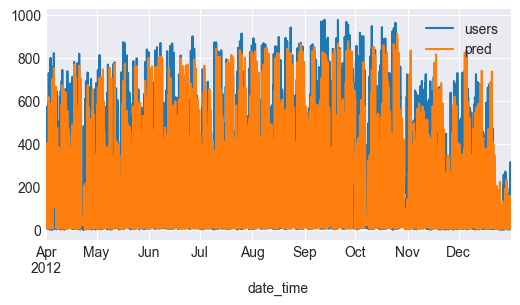

In [42]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'users'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

### 6. Feature Importance and Selection
- Evaluate the importance of each feature in the model.
- [Forecaster explainability: Feature importance, SHAP Values and Partial Dependence Plots in skforecast](https://skforecast.org/latest/user_guides/explainability).
- Select the most relevant features to improve forecast accuracy.
- [Feature selection in skforecast](https://skforecast.org/latest/user_guides/feature-selection).


In [ ]:
X_train, y_train = forecaster.create_train_X_y(
                     y    = data_train['users'],
                     exog = data_train[['holiday', 'workingday']]
                   )

display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,roll_mean_10
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 20:00:00,37.0,35.0,67.0,93.0,110.0,106.0,94.0,84.0,56.0,36.0,...,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0,16.0,71.8
2011-01-01 21:00:00,36.0,37.0,35.0,67.0,93.0,110.0,106.0,94.0,84.0,56.0,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0,71.8
2011-01-01 22:00:00,34.0,36.0,37.0,35.0,67.0,93.0,110.0,106.0,94.0,84.0,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,69.6


date_time
2011-01-01 20:00:00    36.0
2011-01-01 21:00:00    34.0
2011-01-01 22:00:00    28.0
Freq: h, Name: y, dtype: float64

In [46]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(forecaster.regressor)
shap_values = explainer.shap_values(X_train)

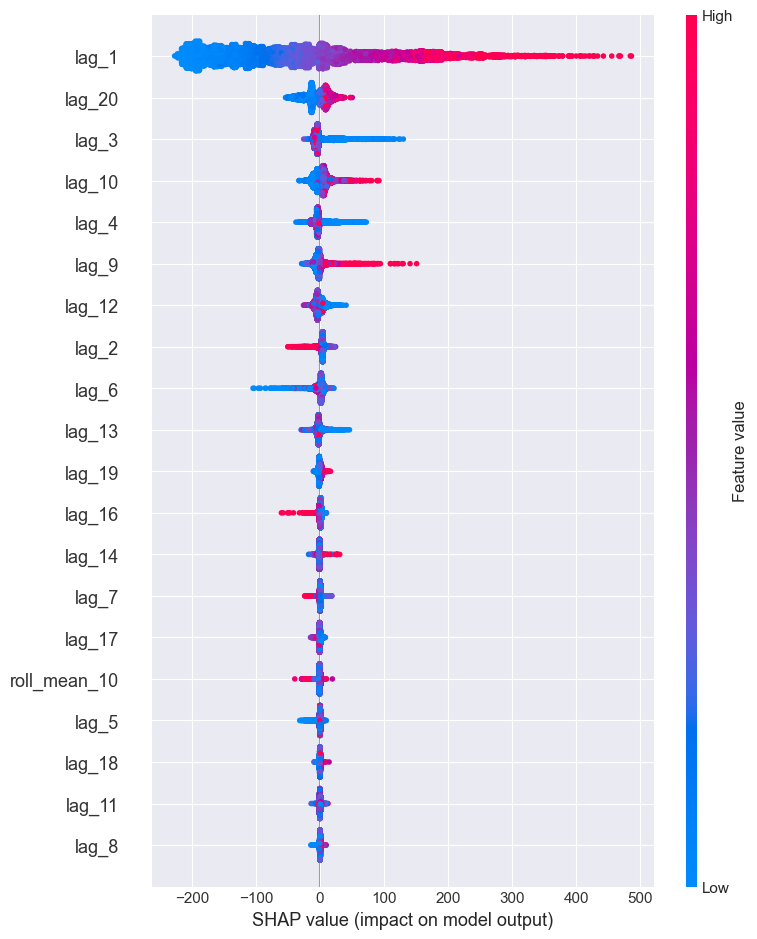

In [47]:
shap.summary_plot(shap_values, X_train)